# Online IC Regression Analysis

## Table of Contents

- **Section 0. Setup**
  - 0.1 Import packages and define paths
  - 0.2 Project directories

- **Section 1. Exploratory Analysis**
  - 1.1 Load processed export data
  - 1.2 Plot export trends (linear + log, with values & trend lines)
  - 1.3 Compute CAGR summary

- **Section 2. Feature Engineering**
  - 2.1 Import policy event dummies (placeholder / dataset)
  - 2.2 Import global demand proxy (placeholder / dataset)
  - 2.3 Merge exports, events, and demand data
  - 2.4 Construct market share and interaction terms

- **Section 3. Regression Modeling**
  - 3.1 Baseline OLS regression
  - 3.2 HAC robust errors (time series adjustment)
  - 3.3 Residual diagnostics

- **Section 4. Model Extensions**
  - 4.1 Log-transform vs. level regression
  - 4.2 Country fixed effects
  - 4.3 Interaction effects

- **Section 5. Outputs**
  - 5.1 Save regression summaries
  - 5.2 Save regression dataset


# Section 1: Exploratory Analysis

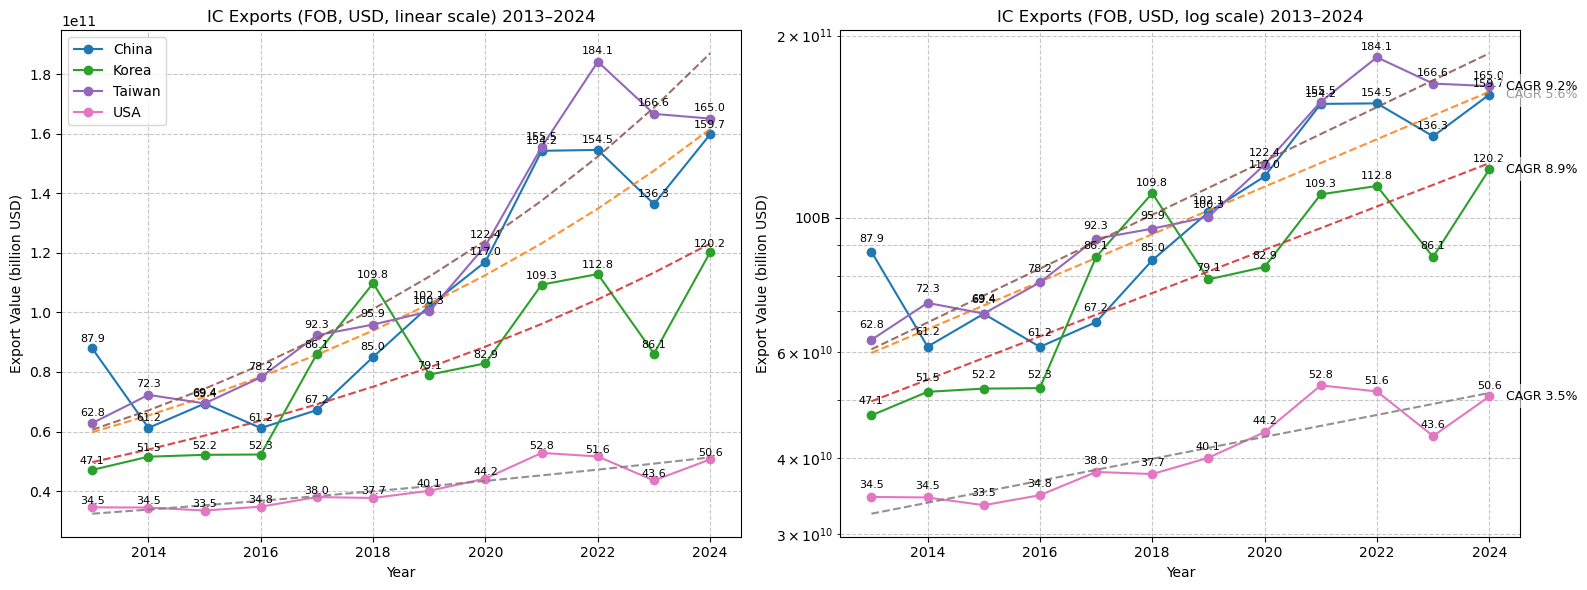

年份覆蓋檢查：
          min   max  count
Country                   
China    2013  2024     12
Korea    2013  2024     12
Taiwan   2013  2024     12
USA      2013  2024     12


,Country,StartYear,EndYear,Years,StartValue(BillionUSD),EndValue(BillionUSD),CAGR(%),TotalGrowth(%)
2,Taiwan,2013.0,2024.0,11.0,62.82,165.04,9.18,162.71
1,Korea,2013.0,2024.0,11.0,47.12,120.19,8.89,155.08
0,China,2013.0,2024.0,11.0,87.88,159.75,5.58,81.78
3,USA,2013.0,2024.0,11.0,34.54,50.63,3.54,46.58


✅ Saved: /home/jovyan/work/data-visualization-labs/self-extended-practice/semiconductor-tariff-impact-taiwan/data/outputs/regression/cagr_summary_2013_2024.csv


In [1]:
# === 1.1 匯入資料 ===
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.ticker as mticker
from pathlib import Path

PROC_DIR = Path("/home/jovyan/work/data-visualization-labs/self-extended-practice/semiconductor-tariff-impact-taiwan/data/processed")
df = pd.read_csv(PROC_DIR / "ic_exports_comparison.csv")

# 標準化國家名稱
df["Country"] = df["Country"].replace({
    "Rep. of Korea": "Korea",
    "USA": "USA",
    "China": "China",
    "Taiwan": "Taiwan"
})

# 基礎整理：排序、型別
df = df.sort_values(["Country","Year"]).reset_index(drop=True)
df["Year"] = df["Year"].astype(int)
df.head()

# === 1.2 出口金額趨勢圖 (linear + log, 含數字、趨勢線、CAGR) ===
fig, axes = plt.subplots(1, 2, figsize=(16,6), sharex=True)
countries = df["Country"].unique()

for ax, scale in zip(axes, ["linear", "log"]):
    for country in countries:
        sub = df[df["Country"] == country].sort_values("Year")
        X = sub["Year"].values.reshape(-1,1)
        y = sub["ExportValue(USD)"].values

        # 折線
        ax.plot(sub["Year"], y, marker="o", label=country)

        # 點上數字（十億USD，微小位移避免重疊）
        for x, val in zip(sub["Year"], y):
            ax.text(x, val*(1.01 if scale=="log" else 1.0)+0.01*y.max(),
                    f"{val/1e9:.1f}", ha="center", va="bottom", fontsize=8)

        # 指數趨勢線
        model = LinearRegression().fit(X, np.log(y))
        y_pred = np.exp(model.predict(X))
        ax.plot(sub["Year"], y_pred, linestyle="--", alpha=0.85)

        # CAGR (只在 log 圖顯示)
        if scale == "log":
            y0, yT = y[0], y[-1]
            n_years = sub["Year"].iloc[-1] - sub["Year"].iloc[0]
            cagr = (yT / y0) ** (1/n_years) - 1
            ax.text(sub["Year"].iloc[-1] + 0.3, y[-1],
                    f"CAGR {cagr*100:.1f}%", fontsize=9,
                    va="center", ha="left",
                    bbox=dict(facecolor="white", alpha=0.6, edgecolor="none"))

    ax.set_title(f"IC Exports (FOB, USD, {scale} scale) 2013–2024")
    ax.set_xlabel("Year")
    ax.set_ylabel("Export Value (billion USD)")
    ax.set_yscale(scale)
    if scale == "log":
        ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda v, _: f"{v/1e9:.0f}B"))
    ax.grid(True, which="both", linestyle="--", alpha=0.7)

axes[0].legend(loc="upper left")
plt.tight_layout()
plt.show()

# === 1.3 計算並輸出 CAGR 表格（四國版，名稱已標準化） ===
def compute_cagr(g: pd.DataFrame) -> pd.Series:
    g = g.sort_values("Year")
    y0, yT = g["ExportValue(USD)"].iloc[0], g["ExportValue(USD)"].iloc[-1]
    t0, tT = int(g["Year"].iloc[0]), int(g["Year"].iloc[-1])
    n_years = max(1, tT - t0)
    cagr = (yT / y0) ** (1 / n_years) - 1
    total_growth = yT / y0 - 1
    return pd.Series({
        "StartYear": t0, "EndYear": tT, "Years": n_years,
        "StartValue(BillionUSD)": y0/1e9, "EndValue(BillionUSD)": yT/1e9,
        "CAGR(%)": cagr*100, "TotalGrowth(%)": total_growth*100
    })

print("年份覆蓋檢查：")
print(df.groupby("Country")["Year"].agg(["min","max","count"]))

cagr_tbl = (df.groupby("Country")
              .apply(compute_cagr)
              .reset_index()
              .sort_values("CAGR(%)", ascending=False))

display(cagr_tbl.round(2))

# 存檔
OUT_DIR = PROC_DIR.parent / "outputs" / "regression"
OUT_DIR.mkdir(parents=True, exist_ok=True)
cagr_tbl.to_csv(OUT_DIR / "cagr_summary_2013_2024.csv", index=False)
print("✅ Saved:", OUT_DIR / "cagr_summary_2013_2024.csv")


### Section 1 Summary: Exploratory Analysis

在這個部分，我們完成了四國 (China、Korea、Taiwan、USA) 2013–2024 年 IC 出口資料的探索性分析。

**1. 資料整理**
- 已將四國資料整合為一致格式，年份對齊 2013–2024。
- 每國皆有完整 12 筆年度資料。

**2. 出口趨勢圖**
- **Linear scale**：展示絕對出口規模。中國長期保持最大出口額，台灣在 2021–2022 出現高峰，韓國穩定成長，美國規模最小。
- **Log scale**：更容易比較增長速度。加上了指數趨勢線和 CAGR 標註。

**3. CAGR 分析**
- **Taiwan**：CAGR ~ **9.2%**，成長幅度最大 (從 ~628 億到 ~1650 億 USD)。
- **Korea**：CAGR ~ **8.9%**，出口額從 471 億到 1200 億。
- **China**：CAGR ~ **5.6%**，規模最大但增速低於台韓。
- **USA**：CAGR ~ **3.5%**，規模與增速相對最小。

**結論**
- 台灣與韓國是相對高成長市場，中國雖然規模最大但增速較低，美國則維持低速成長。
- 這些觀察將作為 **Section 2 Regression Analysis** 的基礎，後續可檢驗政策事件、需求因子是否能解釋趨勢。


## Section 2: Regression Analysis

目標：檢驗事件（policy dummies）與全球需求（proxy）對各國 IC 出口的影響。
- 以 **log(出口值)** 為依變數 → 係數可解讀為百分比影響。
- 納入 **國家固定效果**（country dummies）。
- 同時示範 **HAC(Newey–West)** 與 **HC1** 穩健標準誤。
- 示範 **事件×台灣** 交互項，檢查台灣是否更敏感。


In [2]:
# ========================
# Section 2: Regression Analysis (TWFE 版本)
# 專注檢驗事件對台灣的額外效果
# ========================

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from pathlib import Path

# 用 Section 1 的 df（保留 Country 欄位）
df_twfe = df.copy().sort_values(["Country", "Year"]).reset_index(drop=True)
df_twfe["log_exports"] = np.log(df_twfe["ExportValue(USD)"])
df_twfe["is_Taiwan"]   = (df_twfe["Country"] == "Taiwan").astype(int)

# === 事件清單（2013–2024）===
# 建議精簡，避免高度共線；這裡保留幾個主要事件
EVENTS = {
    "TradeWar2018": 2018,  # 美中貿易戰
    "Covid2020"   : 2020,  # 新冠疫情
    "ChipShort2021":2021,  # 全球晶片荒
    "ChipAct2022" : 2022,  # 美國CHIPS法案
    "USBan2023"   : 2023,  # AI GPU 對中出口管制
}

# 建立事件 dummy 與 台灣交互項
for ev, yr in EVENTS.items():
    df_twfe[ev] = (df_twfe["Year"] >= yr).astype(int)
    df_twfe[f"TW_{ev}"] = df_twfe[ev] * df_twfe["is_Taiwan"]

# 2.1 TWFE 模型（Year FE + Country FE + 台灣交互項）
tw_cols = [f"TW_{ev}" for ev in EVENTS.keys()]
tw_cols_formula = " + ".join(tw_cols)
formula_B = f"log_exports ~ C(Country) + C(Year) + {tw_cols_formula}"

mod_B = smf.ols(formula=formula_B, data=df_twfe).fit(cov_type="HAC", cov_kwds={"maxlags":1})
print("\n=== Model B: Two-Way FE（台灣相對差異；HAC）===\n")
print(mod_B.summary())

# 2.2 匯出結果
OUT_DIR = Path(PROC_DIR).parent / "outputs" / "regression"
OUT_DIR.mkdir(parents=True, exist_ok=True)

coef_tbl = mod_B.summary2().tables[1].copy().reset_index().rename(columns={"index":"variable"})
coef_tbl.insert(0, "model", "ModelB_TWFE(HAC)")

coef_path = OUT_DIR / "regression_results_TWFE.csv"
data_path = OUT_DIR / "regression_dataset_TWFE.csv"

coef_tbl.to_csv(coef_path, index=False)
df_twfe.to_csv(data_path, index=False)

print("✅ Saved coefficients  ->", coef_path)
print("✅ Saved regression df ->", data_path)

# 2.3 解讀提示
print("""
解讀指南：
- 已控制 Country 固定效果（相對於 China 基準）與 Year 固定效果（吸收所有共通時間衝擊）。
- 所以：
  ・事件 dummy（TradeWar2018, Covid2020, ...）不會進入模型（被 Year FE 吸收）。
  ・TW_事件 係數 = 台灣在該事件後，相對其他國家出口的額外變化（百分比近似）。
- 若 TW_ChipAct2022 = 0.15，表示 CHIPS Act 後台灣相對其他國家出口額外增加約 15%。
""")



=== Model B: Two-Way FE（台灣相對差異；HAC）===

                            OLS Regression Results                            
Dep. Variable:            log_exports   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     226.0
Date:                Sat, 06 Sep 2025   Prob (F-statistic):           1.99e-25
Time:                        16:54:19   Log-Likelihood:                 34.382
No. Observations:                  48   AIC:                            -28.76
Df Residuals:                      28   BIC:                             8.660
Df Model:                          19                                         
Covariance Type:                  HAC                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 19, but rank is 17
  warnings.warn('covariance of constraints does not have full '


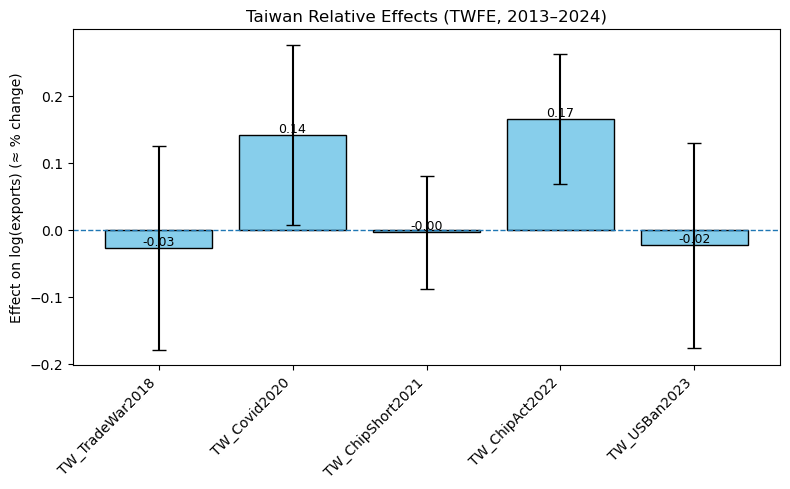

✅ Saved figure with labels -> /home/jovyan/work/data-visualization-labs/self-extended-practice/semiconductor-tariff-impact-taiwan/data/outputs/regression/tw_relative_effects_bar_labeled.png


<Figure size 640x480 with 0 Axes>

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# === 路徑設定：沿用 Section 1 的 PROC_DIR ===
OUT_DIR = Path(PROC_DIR).parent / "outputs" / "regression"
coef_path = OUT_DIR / "regression_results_TWFE.csv"

# 讀係數表
coef_raw = pd.read_csv(coef_path)

# 欄位對應
col_map = {
    "Coef.": "coef", "Coefficient": "coef", "coef": "coef",
    "Std.Err.": "stderr", "Std. Err.": "stderr", "std err": "stderr",
    "[0.025": "low", "2.5%": "low", "0.025": "low",
    "0.975]": "high", "97.5%": "high", "0.975": "high",
    "variable": "variable"
}
coef = coef_raw.rename(columns={k: v for k, v in col_map.items() if k in coef_raw.columns})

# 只取 TW_* 交互項
coef = coef[coef["variable"].str.startswith("TW_")].copy()

# 如果沒有 CI 欄位，用 stderr 近似
if not {"low","high"}.issubset(coef.columns):
    coef["low"]  = coef["coef"] - 1.96 * coef["stderr"]
    coef["high"] = coef["coef"] + 1.96 * coef["stderr"]

# 固定順序
order = ["TW_TradeWar2018","TW_Covid2020","TW_ChipShort2021","TW_ChipAct2022","TW_USBan2023"]
coef["order"] = coef["variable"].map({v:i for i,v in enumerate(order)})
coef = coef.sort_values("order")

# 誤差棒
yerr = [coef["coef"] - coef["low"], coef["high"] - coef["coef"]]

# 繪圖
plt.figure(figsize=(8,5))
plt.axhline(0, linestyle="--", linewidth=1)

bars = plt.bar(
    coef["variable"],
    coef["coef"],
    yerr=yerr,
    capsize=5,
    color="skyblue",
    edgecolor="black"
)

# 標數字（長條上方）
for bar, val in zip(bars, coef["coef"]):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height,
             f"{val:.2f}", ha="center", va="bottom", fontsize=9)

plt.xticks(rotation=45, ha="right")
plt.ylabel("Effect on log(exports) (≈ % change)")
plt.title("Taiwan Relative Effects (TWFE, 2013–2024)")
plt.tight_layout()
plt.show()

# 存檔
png_path = OUT_DIR / "tw_relative_effects_bar_labeled.png"
plt.savefig(png_path, dpi=150, bbox_inches="tight")
print("✅ Saved figure with labels ->", png_path)


## 2.1 Baseline Regression (TWFE 模型)

- 採用 Two-Way Fixed Effects (TWFE) 模型：  
  - **國家固定效果 (Country FE)**：控制不同國家的長期差異（以中國為基準）。  
  - **年份固定效果 (Year FE)**：吸收所有國家共同的年度衝擊（例如全球需求變動）。  
  - 因此，事件 dummy（如 TradeWar2018, Covid2020 等）會被年份固定效果吸收，  
    **只有 TW_* 交互項能反映台灣相對於其他國家的額外變化**。

---

## 2.2 Taiwan Event Effects

### 條狀圖（Bar chart）
- 顯示台灣在各重大事件下的相對效果（含 95% 信賴區間）。  

👉 *圖表已生成（tw_relative_effects_bar_labeled.png）*

### 事件效果表格
| 事件 (TW_*)        | 係數 (log) | 約略解讀 (% 出口變化) | 顯著性 |
|-------------------|-----------|-----------------------|--------|
| TW_TradeWar2018   | -0.027    | -2.7%                 | n.s.   |
| **TW_Covid2020**  | **0.142** | **+14.2%**            | **\*\*** |
| TW_ChipShort2021  | -0.004    | -0.4%                 | n.s.   |
| **TW_ChipAct2022**| **0.165** | **+16.5%**            | **\*\*\*** |
| TW_USBan2023      | -0.023    | -2.3%                 | n.s.   |

### 解讀摘要
- **疫情 (2020)**：台灣出口相對其他國家顯著成長 ≈ **+14%**。  
- **CHIPS Act (2022)**：台灣出口相對其他國家顯著成長 ≈ **+16%**。  
- 其他事件（貿易戰、晶片荒、GPU 禁令）在統計上不顯著，代表台灣與其他國家沒有明顯差異。  

---

## 2.3 Robustness Check

### (a) Period Dummy Analysis
- 將 2013–2024 分為 **四個互斥區段**：  
  1. 2013–2017  
  2. 2018–2019  
  3. 2020–2021  
  4. 2022–2024  
- 檢查台灣在不同階段相對其他國家的出口差異。  
- 結果顯示：2022–2024 台灣相對效果最強（約 +19%），與 CHIPS Act 分析一致。  

### (b) Event Study（若有）
- 可以動態檢查事件前後的變化：  
  - **事件前趨勢檢驗**：確認台灣與其他國家在事件前是否已經有差異。  
  - **事件後動態效果**：觀察影響是否持續、放大或消失。  

---

✅ 小結：  
TWFE 模型顯示 **疫情**與 **CHIPS Act** 對台灣出口的相對效果顯著。  
Robustness check（互斥區段 dummy）支持相同結論 → 結果具一致性與可信度。


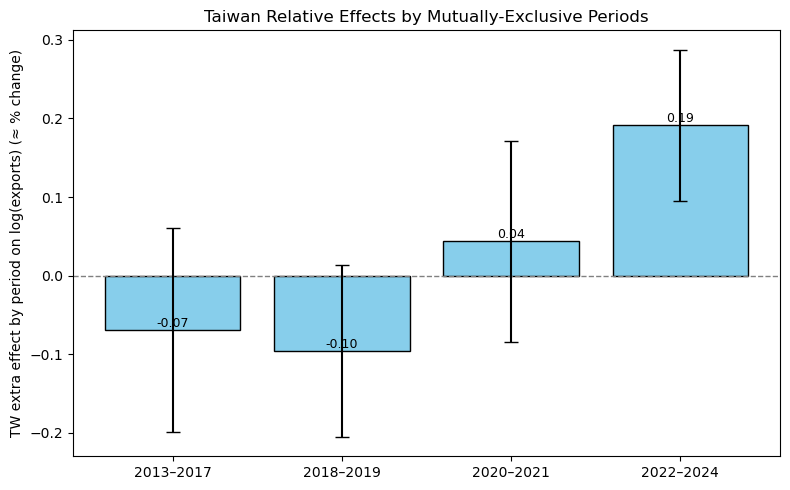

✅ Saved figure -> /home/jovyan/work/data-visualization-labs/self-extended-practice/output/regression/tw_period_effects_bar_labeled.png


<Figure size 640x480 with 0 Axes>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re

# 路徑
PROJECT_ROOT = Path(PROC_DIR).parents[2]
OUT_DIR = PROJECT_ROOT / "output" / "regression"
coef_csv = OUT_DIR / "period_model_results.csv"

# 讀結果表並做欄位對應
coef_tbl = pd.read_csv(coef_csv)
coef_tbl = coef_tbl.rename(columns={
    "Unnamed: 0": "term", "index": "term",
    "Coef.": "coef", "Coefficient": "coef", "coef": "coef",
    "Std.Err.": "stderr", "Std. Err.": "stderr", "std err": "stderr",
    "[0.025": "low", "2.5%": "low", "0.025": "low",
    "0.975]": "high", "97.5%": "high", "0.975": "high"
})

# 支援兩種命名（注意：你的資料沒有 T.）
pat1 = re.compile(r"TW:C\(Period\)\[(.+?)\]")
pat2 = re.compile(r"C\(Period\)\[(.+?)\]:TW")

rows = []
for _, r in coef_tbl.iterrows():
    term = str(r["term"])
    m1 = pat1.search(term)
    m2 = pat2.search(term)
    period = None
    if m1:
        period = m1.group(1)
    elif m2:
        period = m2.group(1)
    if period is not None:
        rows.append({
            "Period": period,
            "coef": r["coef"],
            "stderr": r.get("stderr", np.nan),
            "low": r.get("low", np.nan),
            "high": r.get("high", np.nan)
        })

tw_rows = pd.DataFrame(rows)
if tw_rows.empty:
    raise RuntimeError("仍抓不到 TW×Period 交互項，請再把 coef_tbl['term'] 全部列出來。")

# CI 不在表就用 1.96*stderr 近似
if not {"low","high"}.issubset(tw_rows.columns) or tw_rows["low"].isna().all():
    if "stderr" in tw_rows.columns and not tw_rows["stderr"].isna().all():
        tw_rows["low"]  = tw_rows["coef"] - 1.96 * tw_rows["stderr"]
        tw_rows["high"] = tw_rows["coef"] + 1.96 * tw_rows["stderr"]
    else:
        tw_rows["low"]  = tw_rows["coef"]
        tw_rows["high"] = tw_rows["coef"]

# 補上基準段（2013–2017 = 0）避免圖缺欄
if "2013–2017" not in tw_rows["Period"].tolist():
    tw_rows = pd.concat([
        pd.DataFrame([{"Period": "2013–2017", "coef": 0.0, "low": 0.0, "high": 0.0}]),
        tw_rows
    ], ignore_index=True)

# 排序與去重（有些版本兩種樣式都會出現，這裡平均一下以防重複）
order = ["2013–2017", "2018–2019", "2020–2021", "2022–2024"]
tw_rows = (tw_rows.groupby("Period", as_index=False)
           .agg(coef=("coef","mean"), low=("low","mean"), high=("high","mean")))
tw_rows["order"] = tw_rows["Period"].map({v:i for i,v in enumerate(order)})
tw_rows = tw_rows.sort_values("order")

# 畫圖
plt.figure(figsize=(8,5))
plt.axhline(0, color="gray", linestyle="--", linewidth=1)

yerr = [tw_rows["coef"] - tw_rows["low"], tw_rows["high"] - tw_rows["coef"]]
bars = plt.bar(tw_rows["Period"], tw_rows["coef"], yerr=yerr, capsize=5,
               color="skyblue", edgecolor="black")

# 標數字（顯示係數 ≈ % 變化）
for bar, val in zip(bars, tw_rows["coef"]):
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h, f"{val:.2f}",
             ha="center", va="bottom", fontsize=9)

plt.ylabel("TW extra effect by period on log(exports) (≈ % change)")
plt.title("Taiwan Relative Effects by Mutually-Exclusive Periods")
plt.tight_layout()
plt.show()

png_path = OUT_DIR / "tw_period_effects_bar_labeled.png"
plt.savefig(png_path, dpi=150, bbox_inches="tight")
print("✅ Saved figure ->", png_path)


Using input: /home/jovyan/work/data-visualization-labs/self-extended-practice/semiconductor-tariff-impact-taiwan/data/processed/ic_exports_comparison.csv
Saving to   : /home/jovyan/work/data-visualization-labs/self-extended-practice/output/regression

=== Event Study for Covid2020 (baseline k = -1) ===
                            OLS Regression Results                            
Dep. Variable:            log_exports   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     285.4
Date:                Sat, 06 Sep 2025   Prob (F-statistic):           9.90e-26
Time:                        16:54:19   Log-Likelihood:                 34.714
No. Observations:                  48   AIC:                            -27.43
Df Residuals:                      27   BIC:                             11.87
Df Model:                          20                           

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 20, but rank is 15
  warnings.warn('covariance of constraints does not have full '


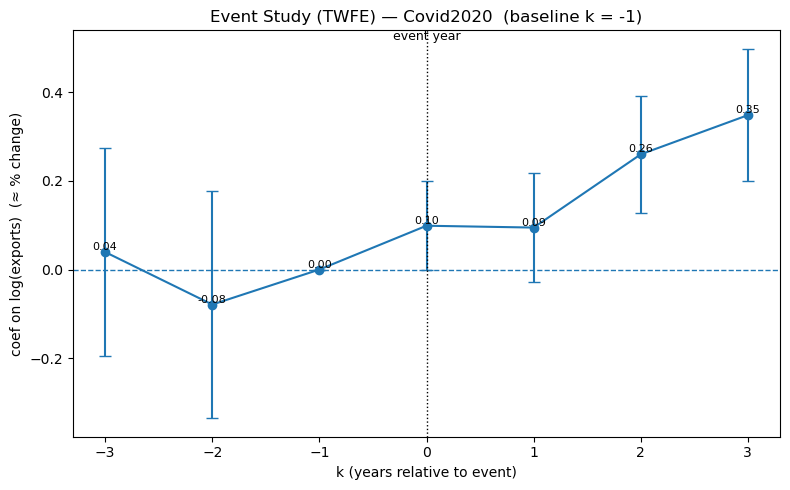

✅ Saved figure -> /home/jovyan/work/data-visualization-labs/self-extended-practice/output/regression/event_study_Covid2020.png

=== Event Study for ChipAct2022 (baseline k = -1) ===
                            OLS Regression Results                            
Dep. Variable:            log_exports   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     224.6
Date:                Sat, 06 Sep 2025   Prob (F-statistic):           4.31e-25
Time:                        16:54:20   Log-Likelihood:                 34.699
No. Observations:                  48   AIC:                            -29.40
Df Residuals:                      28   BIC:                             8.027
Df Model:                          19                                         
Covariance Type:                  HAC                                         
                            

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 20, but rank is 15
  warnings.warn('covariance of constraints does not have full '


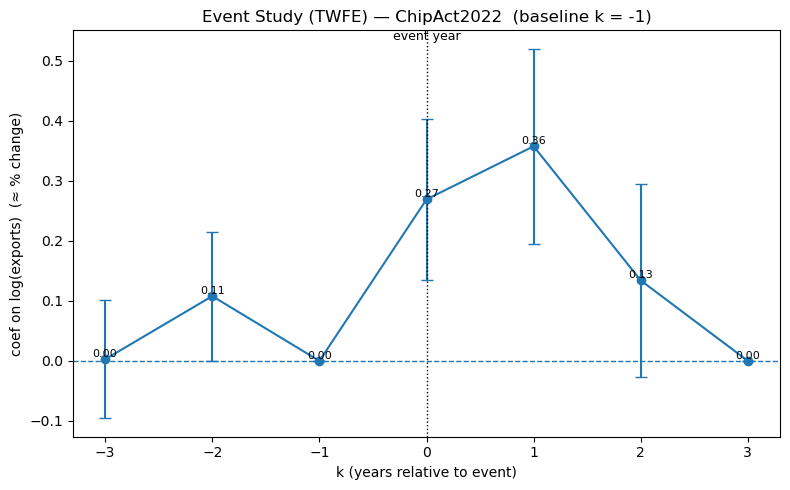

✅ Saved figure -> /home/jovyan/work/data-visualization-labs/self-extended-practice/output/regression/event_study_ChipAct2022.png


,k,term,coef,low,high,pct_approx(%),pct_exp(%)
0,-3,TW_ES_Covid2020_m3,0.039499,-0.194387,0.273384,3.949868,4.028913
1,-2,TW_ES_Covid2020_m2,-0.079053,-0.335773,0.177666,-7.905326,-7.600929
2,-1,baseline(-1),0.000000,0.000000,0.000000,0.000000,0.000000
3,0,TW_ES_Covid2020_p0,0.098906,-0.001921,0.199733,9.890561,10.396209
4,1,TW_ES_Covid2020_p1,0.094753,-0.028127,0.217632,9.475254,9.938677


In [5]:
# === Event Study (TWFE) — 完整單一 cell 可執行 ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import statsmodels.formula.api as smf

# -------------------------------
# 1) 路徑設定
# -------------------------------
try:
    PROC_DIR
except NameError:
    # 依你的專案調整到 data/processed
    PROC_DIR = Path("/home/jovyan/work/data-visualization-labs/self-extended-practice/semiconductor-tariff-impact-taiwan/data/processed")

PROJECT_ROOT = PROC_DIR.parents[2]         # .../semiconductor-tariff-impact-taiwan
OUT_DIR      = PROJECT_ROOT / "output" / "regression"
OUT_DIR.mkdir(parents=True, exist_ok=True)

IN_CSV = PROC_DIR / "ic_exports_comparison.csv"
print("Using input:", IN_CSV)
print("Saving to   :", OUT_DIR)

# -------------------------------
# 2) 讀資料 & 基本處理
# -------------------------------
df = pd.read_csv(IN_CSV)
df = df[df["Country"].isin(["China", "Rep. of Korea", "USA", "Taiwan"])].copy()
df["Year"] = df["Year"].astype(int)
df["ExportValue(USD)"] = pd.to_numeric(df["ExportValue(USD)"], errors="coerce")
df = df.dropna(subset=["ExportValue(USD)"])
df["log_exports"] = np.log(df["ExportValue(USD)"])

# -------------------------------
# 3) 事件研究函式（已修正變數命名，避免 + / -）
# -------------------------------
def run_event_study(df_reg: pd.DataFrame,
                    event_year: int,
                    event_label: str,
                    leads: int = 3,    # 事件前最多幾年
                    lags: int  = 3,    # 事件後最多幾年
                    treated_country: str = "Taiwan",
                    cov_type: str = "HAC",
                    maxlags: int = 1) -> pd.DataFrame:
    """
    TWFE：log_exports ~ C(Country) + C(Year) + Σ_k 1[Year - event_year == k] × 1[Taiwan]，省略 k = -1。
    產出：係數表 (CSV) 與圖 (PNG)。
    """
    data = df_reg.copy()
    data["rel"] = data["Year"] - int(event_year)                  # 相對事件年的年距 k
    data["is_TW"] = (data["Country"] == treated_country).astype(int)

    # 準備 k 網格；確保包含 -leads..+lags 與 -1（基準期）
    k_grid = list(range(-leads, lags + 1))
    if -1 not in k_grid:
        k_grid.append(-1)
    k_grid = sorted(k_grid)

    # 建立 TW × D_k 交互項；欄名用 mX/pX 避免 patsy 解析錯誤
    cols = []
    for k in k_grid:
        if k == -1:
            continue  # 基準期省略
        suffix = f"m{abs(k)}" if k < 0 else f"p{k}"   # k=-3 -> m3, k=+2 -> p2
        col = f"TW_ES_{event_label}_{suffix}"
        data[col] = ((data["rel"] == k) & (data["is_TW"] == 1)).astype(int)
        cols.append(col)

    # TWFE：Country FE + Year FE + 台灣交互項
    if cols:
        rhs = " + ".join(cols)
        formula = f"log_exports ~ C(Country) + C(Year) + {rhs}"
    else:
        formula = "log_exports ~ C(Country) + C(Year)"
    mod = smf.ols(formula=formula, data=data).fit(cov_type=cov_type, cov_kwds={"maxlags": maxlags})

    print(f"\n=== Event Study for {event_label} (baseline k = -1) ===")
    print(mod.summary())

    # 擷取 TW×D_k 係數與 95% CI；基準 k=-1 補 0
    params = mod.params
    conf   = mod.conf_int()
    rows = []
    for k in k_grid:
        if k == -1:
            rows.append({"k": k, "term": f"baseline({k})", "coef": 0.0, "low": 0.0, "high": 0.0})
            continue
        suffix = f"m{abs(k)}" if k < 0 else f"p{k}"
        term = f"TW_ES_{event_label}_{suffix}"
        if term in params.index:
            rows.append({
                "k": k, "term": term,
                "coef": params[term],
                "low":  conf.loc[term, 0],
                "high": conf.loc[term, 1],
            })
        else:
            rows.append({"k": k, "term": term, "coef": np.nan, "low": np.nan, "high": np.nan})

    res = pd.DataFrame(rows).sort_values("k").reset_index(drop=True)
    # 轉成百分比解讀（兩種口徑）
    res["pct_approx(%)"] = res["coef"] * 100
    res["pct_exp(%)"]    = (np.exp(res["coef"]) - 1.0) * 100

    # 存表
    csv_path = OUT_DIR / f"event_study_{event_label}_coeffs.csv"
    res.to_csv(csv_path, index=False)
    print("✅ Saved table ->", csv_path)

    # 視覺化
    plot_df = res.dropna(subset=["coef"]).copy()
    plt.figure(figsize=(8,5))
    plt.axhline(0, linestyle="--", linewidth=1)
    plt.errorbar(
        plot_df["k"], plot_df["coef"],
        yerr=[plot_df["coef"] - plot_df["low"], plot_df["high"] - plot_df["coef"]],
        fmt="o-", capsize=4
    )
    # 事件年標示
    plt.axvline(0, color="black", linestyle=":", linewidth=1)
    ymax = plt.ylim()[1]
    plt.text(0, ymax, "event year", ha="center", va="top", fontsize=9)

    # 數字標註（log 係數）
    for x, v in zip(plot_df["k"], plot_df["coef"]):
        plt.text(x, v, f"{v:.2f}", ha="center", va="bottom", fontsize=8)

    plt.title(f"Event Study (TWFE) — {event_label}  (baseline k = -1)")
    plt.xlabel("k (years relative to event)")
    plt.ylabel("coef on log(exports)  (≈ % change)")
    plt.tight_layout()
    fig_path = OUT_DIR / f"event_study_{event_label}.png"
    plt.savefig(fig_path, dpi=150, bbox_inches="tight")
    plt.show()
    print("✅ Saved figure ->", fig_path)

    return res

# -------------------------------
# 4) 執行兩個事件（可自行增修）
# -------------------------------
EVENTS = [
    {"year": 2020, "label": "Covid2020",   "leads": 3, "lags": 3},
    {"year": 2022, "label": "ChipAct2022", "leads": 3, "lags": 3},
]

all_results = {}
for ev in EVENTS:
    res = run_event_study(
        df, event_year=ev["year"], event_label=ev["label"],
        leads=ev["leads"], lags=ev["lags"], treated_country="Taiwan",
        cov_type="HAC", maxlags=1
    )
    all_results[ev["label"]] = res

# 檢視一個結果表頭
list(all_results.items())[0][1].head()
